# 2019/3/24にmatplotlibのアニメーションの機能に関する発表を行いました #

2019/3/24に「はんなりPython+PyData Osakaの可視化特集会 」のイベントにて標題の発表を行いました。
イベントページは[こちら](https://pydataosaka.connpass.com/event/124089/)です。
発表資料はいつものように下記のnotebookをRISEでスライドにしたものを使用しました。

In [8]:
from IPython.display import IFrame
IFrame("https://www.hiromasa.info/slide/15.slides.html", "100%", "450px")

## matplotlibのアニメーション機能の紹介 ##

## 自己紹介 ##

* 大橋宏正(@wrist)
* PyData Osaka オーガナイザ
* メーカー職(音響信号処理の業務に従事)

## 概要 ##

* matplotlibのアニメーション機能を紹介
* 単純な方法の紹介(plt.pause)
* Animationクラスを用いた方法の紹介
    * ArtistAnimation, FuncAnimation
    * TimedAnimation
* 動画書き出し

## なぜアニメーション描画を行いたいか ##

* センサーデータの時系列変化を可視化したい
    * ex. PCM信号
    * c/c++バイナリが吐いたdumpデータの描画

In [1]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
print(np.__version__)
print(sp.__version__)
print(mpl.__version__)

1.16.2
1.2.1
3.0.3


In [3]:
# osxの場合
%matplotlib osx

## osxの場合の制約 ##

* アニメーション描画
    * backendに"osx"の指定が必要
* "osx"の指定
    * FrameworkとしてビルドされたPythonが必要
    * 仮想環境(conda含む)のPythonはFrameworkビルドではない

## osx(conda)の場合の対処方法 ##

* [公式FAQでの対処法](https://matplotlib.org/faq/osx_framework.html#conda)
    * `conda install python.app`
    * pythonの代わりにpythonwを実行
    * pythonwを使うkernelを作成すればjupyter notebook上でも実行可能

## pythonwを使用するカーネルの作成方法 ##

* 要ipykernel

```sh
$ ipython kernel install --user --name pythonw3 --display-name pythonw3
$ jupyter kernelspec list  # pythonw3カーネルのパスを確認
$ vim ~/.pyenv/versions/miniconda3-4.3.30/envs/py36/share/jupyter/kernels/pythonw3/kernel.json # kernel.json記載のpathをpythonwに変更
```

実際の実行結果

```sh
$ jupyter kernelspec list
Available kernels:
  julia-0.4    /Users/wrist/Library/Jupyter/kernels/julia-0.4
  julia_0.3    /Users/wrist/Library/Jupyter/kernels/julia_0.3
  python3      /Users/wrist/.pyenv/versions/miniconda3-4.3.30/envs/py36/share/jupyter/kernels/python3

$ ipython kernel install --user --name pythonw3 --display-name pythonw3
Installed kernelspec pythonw3 in /Users/wrist/Library/Jupyter/kernels/pythonw3

$ jupyter kernelspec list
Available kernels:
  julia-0.4    /Users/wrist/Library/Jupyter/kernels/julia-0.4
  julia_0.3    /Users/wrist/Library/Jupyter/kernels/julia_0.3
  pythonw3     /Users/wrist/Library/Jupyter/kernels/pythonw3
  python3      /Users/wrist/.pyenv/versions/miniconda3-4.3.30/envs/py36/share/jupyter/kernels/python3

# condaのpython3と同じディレクトリに移動
$ mv ~/Library/Jupyter/kernels/pythonw3 ~/.pyenv/versions/miniconda3-4.3.30/envs/py36/share/jupyter/kernels/
/Users/wrist/Library/Jupyter/kernels/pythonw3 -> /Users/wrist/.pyenv/versions/miniconda3-4.3.30/envs/py36/share/jupyter/kernels/pythonw3

$ jupyter kernelspec list
Available kernels:
  julia-0.4    /Users/wrist/Library/Jupyter/kernels/julia-0.4
  julia_0.3    /Users/wrist/Library/Jupyter/kernels/julia_0.3
  python3      /Users/wrist/.pyenv/versions/miniconda3-4.3.30/envs/py36/share/jupyter/kernels/python3
  pythonw3     /Users/wrist/.pyenv/versions/miniconda3-4.3.30/envs/py36/share/jupyter/kernels/pythonw3

# kernel.jsonに記載されているpathをpythonwに書き直す
$ vim ~/.pyenv/versions/miniconda3-4.3.30/envs/py36/share/jupyter/kernels/pythonw3/kernel.json
```

## 最も単純なアニメーション方法 ##

* `plt.pause(second)`を使って描画を繰り返す
    * `plt.plot()`,`plt.pause(sec)`, `plt.cla()`を繰り返す

In [4]:
# 説明上の共通コード
plt.close("all")
dx = np.pi / 10.0
xs = np.arange(-np.pi, np.pi, dx)

fig = plt.figure(1)
ax = fig.add_subplot(111)

In [5]:
# アニメーションしないバージョン
for _ in range(100):
    ax.plot(xs, np.sin(xs)); xs += dx;
plt.show()

In [6]:
# 説明上の共通コード
plt.close("all")
dx = np.pi / 10.0
xs = np.arange(-np.pi, np.pi, dx)

fig = plt.figure(1)
ax = fig.add_subplot(111)

In [7]:
# アニメーションするバージョン
for n in range(100):
    ax.plot(xs, np.sin(xs)); xs += dx;
    plt.pause(0.1); plt.cla();  # 0.1s待ってclear
plt.show()

In [8]:
# アニメーションするバージョン
for n in range(100):
    ax.plot(xs, np.sin(xs)); xs += dx;
    plt.pause(0.1); ax.clear(); # ax.clearでも良い
plt.show()

## plotのコストを下げる ##

* `ax.plot`は毎回プロットし直すためコストが大きい
* linesを取得して毎回set_dataでデータを設定

In [9]:
# 説明上の共通コード
plt.close("all")
dx = np.pi / 10.0
xs = np.arange(-np.pi, np.pi, dx)

fig = plt.figure(1)
ax = fig.add_subplot(111)

In [10]:
lines = ax.plot(xs, np.sin(xs))
for n in range(100):
    lines[0].set_data(xs, np.sin(xs)); xs += dx;
    ax.set_xlim((np.min(xs), np.max(xs)))  # 横軸範囲の再設定
    plt.pause(0.1)  # clear不要
plt.show()

## `plt.ion()`, `plt.draw()`を使う方法 ##

* 昔の記事でよく出てくる方法
    * `plt.ion()` -> `plt.show()`
    * `ax.plot()` -> `plt.draw()` -> `plt.cla()`を繰り返す
    * インタラクティブモードをonにした上で再描画を都度命令
* windowsでは過去は確かにこれでいけた(現状は未確認)
* 手元のosxだと`plt.pause`を入れないと動作しない
    * `plt.ion()`しておく必要は特にない？

In [11]:
print(plt.isinteractive())

True


In [12]:
# 説明上の共通コード
plt.close("all")
dx = np.pi / 10.0; xs = np.arange(-np.pi, np.pi, dx)
fig = plt.figure(1); ax = fig.add_subplot(111)

In [13]:
plt.ion(); plt.show();
for n in range(100):
    ax.plot(xs, np.sin(xs)); xs += dx
    plt.draw(); plt.pause(0.1); plt.cla();

In [14]:
print(plt.isinteractive())

True


In [15]:
plt.ioff()

In [16]:
print(plt.isinteractive())

False


## matplotlibのアニメーション描画クラス ##

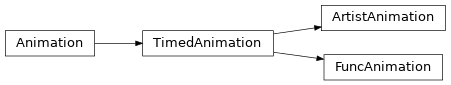

In [6]:
from IPython.display import Image
Image("./15/animation_class.png")

* https://matplotlib.org/api/animation_api.html より引用
* プロットのリストを与えて描画するArtistAnimation
* 描画関数とデータ配列を与えて描画するFuncAnimation

## ArtistAnimation ##

* 描画するプロットのリストを予め作成し与える
* アニメーション描画クラスの中でも単純なクラス

`class matplotlib.animation.ArtistAnimation(fig, artists, *args, **kwargs)`

* artists
    * 各フレームで描画するArtistコレクションのlist

In [17]:
import matplotlib.animation as anim

In [18]:
plt.close("all")
dx = np.pi / 10.0
xs = np.arange(-np.pi, np.pi, dx)
interval_ms = 100
images = []

In [19]:
fig = plt.figure(1); ax = fig.add_subplot(111)
for _ in range(100):
    images.append(ax.plot(xs , np.sin(xs))); xs += dx;
ani = anim.ArtistAnimation(fig, images, interval=interval_ms, repeat=False)    
plt.show()

## 問題点 ##

* 範囲制御ができていない
* 理由
    * xsの範囲が都度増加しているため
* 対策
    * xsを固定
    * x軸レンジが固定されてしまう

In [20]:
plt.close("all")
dx = np.pi / 10.0
xs = np.arange(-np.pi, np.pi, dx)
interval_ms = 100
images = []

In [21]:
fig = plt.figure(1); ax = fig.add_subplot(111)
for n in range(100):
    images.append(ax.plot(xs , np.sin(xs + n*dx)))
ani = anim.ArtistAnimation(fig, images, interval=interval_ms, repeat=False)    
plt.show()

## FuncAnimation ##

* 描画関数とデータ配列を与えてアニメーション
* データ配列はgeneratorなどでも良い

`class matplotlib.animation.FuncAnimation(fig, func, frames=None, init_func=None, fargs=None, save_count=None, **kwargs)`

* func : callable
    * `def func(frame, *fargs) -> iterable_of_artists`
    * framesで指定されたデータが渡される
* init_func : callable, optional
    * `def init_func() -> iterable_of_artists`

* frames : iterable, int, generator function, or None, optional
    * iterable: イテレーション可能なデータから描画データを供給
    * integer: 連番range(frames)を供給
    * generator function:  `def gen_function() -> obj`を指定
    * None: `itertools.count`を供給

In [22]:
import matplotlib.animation as anim

In [23]:
plt.close("all")
dx = np.pi / 10.0
xs = np.arange(-np.pi, np.pi, dx)
ys = np.sin(xs)
interval_ms = 100

In [24]:
# 呼び出しごとにデータを生成するジェネレータ
def gen_data():
    counter = 0
    dx = np.pi / 10.0
    xs = np.arange(-np.pi, np.pi, dx)
    while counter < 100:
        ys = np.sin(xs); xs += dx;
        counter += 1
        yield (xs, ys)

In [25]:
fig = plt.figure(1); ax = fig.add_subplot(111)
gline2d = ax.plot(xs, ys)[0]  # これを上書き

def update_data(data):
    xs, ys = data
    ax.set_xlim((np.min(xs), np.max(xs)))
    gline2d.set_data(xs, ys)
    return gline2d
    
ani = anim.FuncAnimation(fig, update_data, gen_data,
                         interval=interval_ms, repeat=False)
plt.show()

* `update_data`でx軸レンジを都度再設定できる

## FuncAnimationを用いたアニメーション描画クラス ##

* 先の例はグローバル変数を直接上書きしているため気持ち悪い
* クラス化することで状態を同時に保持可能
* generatorや描画関数はインスタンスメソッドにできる

In [26]:
class MyAnimation:
    def __init__(self):
        plt.close("all")
        self.fig = plt.figure(1)
        self.ax = self.fig.add_subplot(111)
        self.dx = np.pi / 10.0
        self.xs = np.arange(-np.pi, np.pi, self.dx)
        self.ys = np.sin(self.xs)
        self.interval_ms = 100
        self.line2d = self.ax.plot(self.xs, self.ys)[0]
        self.counter = 0
    
    def gen(self):
        while self.counter < 100:
            self.ys = np.sin(self.xs)
            self.xs += self.dx;
            self.counter += 1
            yield (self.xs, self.ys)
            
    def update_data(self, data):
        xs, ys = data
        self.ax.set_xlim((np.min(xs), np.max(xs)))
        self.line2d.set_data(xs, ys)
        return self.line2d

    def animate(self):
        ani = anim.FuncAnimation(self.fig, self.update_data, self.gen,
                         interval=self.interval_ms, repeat=False)
        plt.show()

In [27]:
MyAnimation().animate()

## TimedAnimation ##

* `ArtistAnimation`、`FuncAnimation`が継承しているクラス
* 自作クラスで継承し下記メソッドを定義して使用
    * `self._draw_frame(self, frame)`
    * `self.new_frame_seq(self)`
    * `self._init_draw(self)`

In [28]:
class MyTimedAnimation(anim.TimedAnimation):
    def __init__(self):
        plt.close("all")
        self.fig = plt.figure(1)
        self.ax = self.fig.add_subplot(111)
        self.dx = np.pi / 10.0
        self.xs = np.arange(-np.pi, np.pi, self.dx)
        self.ys = np.sin(self.xs)
        self.interval_ms = 100
        self.line2d = self.ax.plot(self.xs, self.ys)[0]
        self.counter = 0

        plt.show()
        anim.TimedAnimation.__init__(self, self.fig, self.interval_ms)
    
    def new_frame_seq(self):
        while self.counter < 100:
            self.ys = np.sin(self.xs)
            self.xs += self.dx;
            self.counter += 1
            yield (self.xs, self.ys)
            
    def _draw_frame(self, data):
        xs, ys = data
        self.ax.set_xlim((np.min(xs), np.max(xs)))
        self.line2d.set_data(xs, ys)
        return self.line2d

    def _init_draw(self):
        pass

In [29]:
MyTimedAnimation()

## 動画書き出し ##

* `save`メソッド
    * アニメーションを動画としてファイル保存可能
    * `save(filename, writer="ffmpeg")`
        * writerは文字列 or MovieWriterを継承したクラスを指定
* `to_html5_video`メソッド
    * videoタグを生成

`save(filename, writer=None, fps=None, dpi=None, codec=None, bitrate=None, extra_args=None, metadata=None, extra_anim=None, savefig_kwargs=None)`

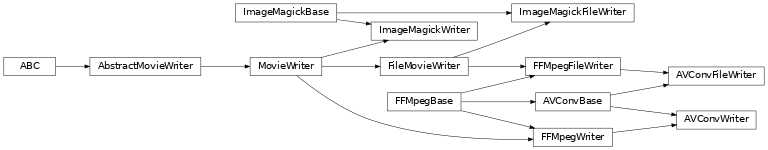

In [7]:
Image("./15/animation_inheritance.png")

In [30]:
plt.close("all")
dx = np.pi / 10.0
xs = np.arange(-np.pi, np.pi, dx)
interval_ms = 100
images = []

In [31]:
fig = plt.figure(1); ax = fig.add_subplot(111)
for _ in range(100):
    images.append(ax.plot(xs , np.sin(xs))); xs += dx;
ani = anim.ArtistAnimation(fig, images, interval=interval_ms, repeat=False)    
ani.save("./test.gif", "imagemagick")

In [32]:
!ls

animation_class.webp
animation_inheritance.webp
pydata_osaka_20190323_matplotlib_animation.ipynb
test.gif


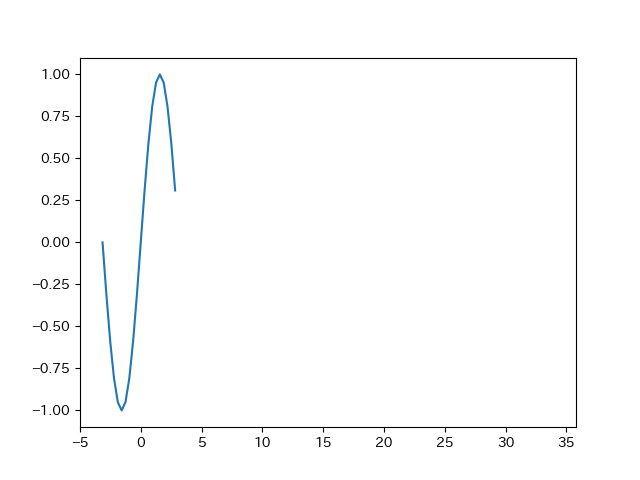

In [4]:
Image("./15/test.gif")

In [33]:
# 要ffmpeg
from IPython.display import HTML
HTML(ani.to_html5_video())

## まとめ ##

* matplotlibのアニメーション機能を紹介
    * 単純な方法
    * ArtistAnimation, FuncAnimation, TimedAnimation
    * 動画書き出しの方法